# Strategy for Buy & Sell(Swing Trading)

Objective: We will code a strategy to exit any position which can be buy, sell, hold or no position. With this strategy will will identify the opportunity to get on board with relly(long and short both) and deboard when stop loss get triggered.

In [1]:
import numpy as np
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import copy
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 200)
pd.set_option('display.min_rows', 100)

In [3]:
#using ATR strategy to exit the positions
#function to calculate True Range and Average True Range
def ATR(DF, n):
    df = DF.copy()
    df['H-L'] = abs(df['High'] - df['Low'])
    df['H-PC'] = abs(df['High'] - df['Adj Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Adj Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1, skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    # df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L', 'H-PC', 'L-PC'], axis=1)
    return df2['ATR']

In [4]:
# Download historical data (monthly) for selected stocks
tickers = ["LYFT", "AAPL", "AMZN", "TSLA", "MSFT"]

In [5]:
ohlc_intraday = {}  # directory with ohlc value for each stock
key_path = "C:\\Users\\punit\\Desktop\\9010\\AplhaVantageKey.txt"
ts = TimeSeries(key=open(key_path, 'r').read(), output_format='pandas')

In [6]:
attempt = 0  # initializing passthrough variable
drop = []  # initializing list to store tickers whose close price was successfully extracted
while len(tickers) != 0 and attempt <= 5:
    tickers = [j for j in tickers if j not in drop]
    for i in range(len(tickers)):
        ohlc_intraday[tickers[i]] = ts.get_intraday(symbol=tickers[i], interval='1min', outputsize='full')[0] #alpha vantage also gives metadata at position 1, so at 0 there is data which we requires(ohlcv data)
        ohlc_intraday[tickers[i]].columns = ["Open", "High", "Low", "Adj Close", "Volume"]
        drop.append(tickers[i])
    attempt += 1

tickers = ohlc_intraday.keys()  # redefine tickers variable after removing any tickers with corrupted data

In [7]:
# calculating ATR and rolling max price for each stock and consolidating this info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print("calculating ATR and rolling max price for ", ticker)
    ohlc_dict[ticker]["ATR"] = ATR(ohlc_dict[ticker], 20)
    ohlc_dict[ticker]["roll_max_cp"] = ohlc_dict[ticker]["High"].rolling(20).max()
    ohlc_dict[ticker]["roll_min_cp"] = ohlc_dict[ticker]["Low"].rolling(20).min()
    ohlc_dict[ticker]["roll_max_vol"] = ohlc_dict[ticker]["Volume"].rolling(20).max()
    ohlc_dict[ticker].dropna(inplace=True)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []

calculating ATR and rolling max price for  LYFT
calculating ATR and rolling max price for  AAPL
calculating ATR and rolling max price for  AMZN
calculating ATR and rolling max price for  TSLA
calculating ATR and rolling max price for  MSFT


In [8]:
# identifying signals and calculating daily return (stop loss factored in)
for ticker in tickers:
    print("calculating returns for ", ticker)
    for i in range(len(ohlc_dict[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_dict[ticker]["High"][i] >= ohlc_dict[ticker]["roll_max_cp"][i] and \
                    ohlc_dict[ticker]["Volume"][i] > 1.5 * ohlc_dict[ticker]["roll_max_vol"][i - 1]:
                tickers_signal[ticker] = "Buy"
            elif ohlc_dict[ticker]["Low"][i] <= ohlc_dict[ticker]["roll_min_cp"][i] and \
                    ohlc_dict[ticker]["Volume"][i] > 1.5 * ohlc_dict[ticker]["roll_max_vol"][i - 1]:
                tickers_signal[ticker] = "Sell"

        elif tickers_signal[ticker] == "Buy":
            if ohlc_dict[ticker]["Adj Close"][i] < ohlc_dict[ticker]["Adj Close"][i - 1] - ohlc_dict[ticker]["ATR"][i - 1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Adj Close"][i - 1] - ohlc_dict[ticker]["ATR"][i - 1]) /
                                            ohlc_dict[ticker]["Adj Close"][i - 1]) - 1)
            elif ohlc_dict[ticker]["Low"][i] <= ohlc_dict[ticker]["roll_min_cp"][i] and \
                    ohlc_dict[ticker]["Volume"][i] > 1.5 * ohlc_dict[ticker]["roll_max_vol"][i - 1]:
                tickers_signal[ticker] = "Sell"
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Adj Close"][i - 1] - ohlc_dict[ticker]["ATR"][i - 1]) /
                                            ohlc_dict[ticker]["Adj Close"][i - 1]) - 1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Adj Close"][i] / ohlc_dict[ticker]["Adj Close"][i - 1]) - 1)

        elif tickers_signal[ticker] == "Sell":
            if ohlc_dict[ticker]["Adj Close"][i] > ohlc_dict[ticker]["Adj Close"][i - 1] + ohlc_dict[ticker]["ATR"][i - 1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append((ohlc_dict[ticker]["Adj Close"][i - 1] / (
                            ohlc_dict[ticker]["Adj Close"][i - 1] + ohlc_dict[ticker]["ATR"][i - 1])) - 1)
            elif ohlc_dict[ticker]["High"][i] >= ohlc_dict[ticker]["roll_max_cp"][i] and \
                    ohlc_dict[ticker]["Volume"][i] > 1.5 * ohlc_dict[ticker]["roll_max_vol"][i - 1]:
                tickers_signal[ticker] = "Buy"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Adj Close"][i - 1] / (
                            ohlc_dict[ticker]["Adj Close"][i - 1] + ohlc_dict[ticker]["ATR"][i - 1])) - 1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Adj Close"][i - 1] / ohlc_dict[ticker]["Adj Close"][i]) - 1)

    ohlc_dict[ticker]["ret"] = np.array(tickers_ret[ticker])

calculating returns for  LYFT
calculating returns for  AAPL
calculating returns for  AMZN
calculating returns for  TSLA
calculating returns for  MSFT


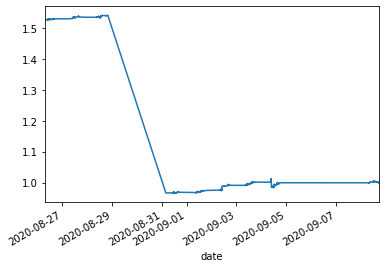

In [9]:
# vizualization of strategy return
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_dict[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
(1 + strategy_df["ret"]).cumprod().plot()